Learn iterator for multiphase elastic problems using PAC-FEANet

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
from functools import reduce

from utils import plot
import feanet.pac as pac
from feanet.model import PACFEANet
from feanet.jacobi import JacobiBlock
from data.dataset import ThermalDataSet

Test PAC-FEANet for thermal problems

In [6]:
device_predict = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #torch.device('cpu') #
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
train = False # True or False
smoother_model = 'thermal_type2_1phase_33x33_smoother'
model_name = 'thermal_type2_2phase_33x33_attention'
training_set = ThermalDataSet('data/thermal/thermal_type2_2phase_33x33.h5', device)
model_dir = 'model/learn_iterator/thermal_type2'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

nb_layers = 3
bs = 5
train_dataloader = DataLoader(training_set, batch_size=bs, shuffle=True)
dirich_idx_train, dirich_value_train, neumann_idx_train, neumann_value_train, material_train, f_train, u_train = next(iter(train_dataloader))
k = 0 # the index of training data to be shown

In [8]:
n_test = 2**5
test_set = ThermalDataSet('data/thermal/thermal_type2_nphase_33x33.h5', device)

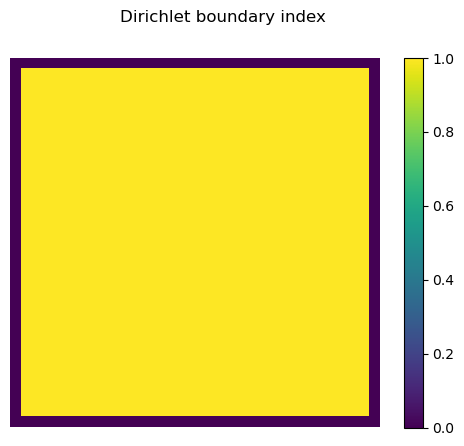

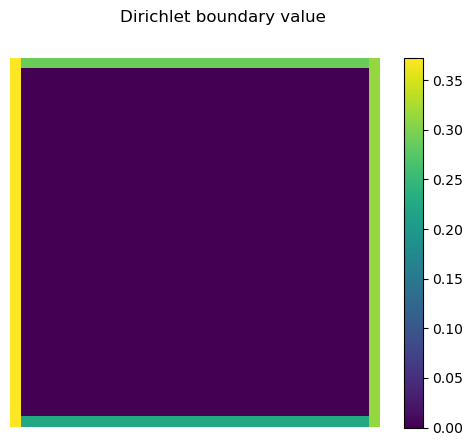

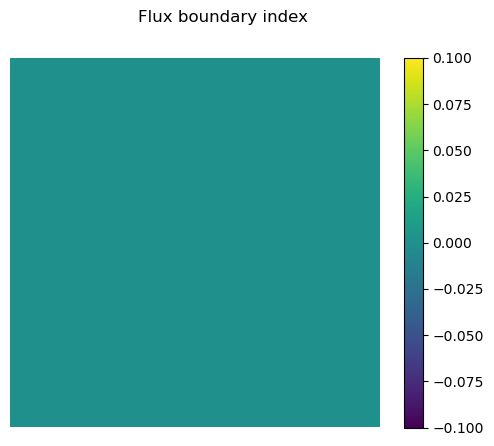

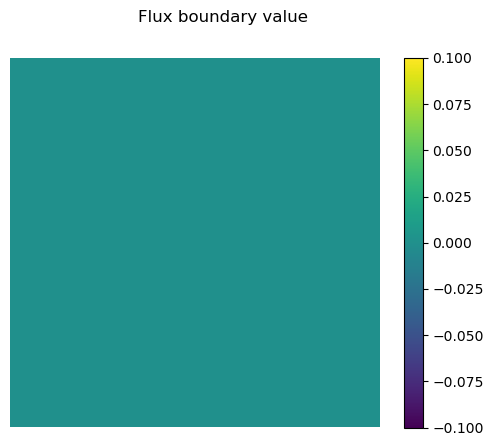

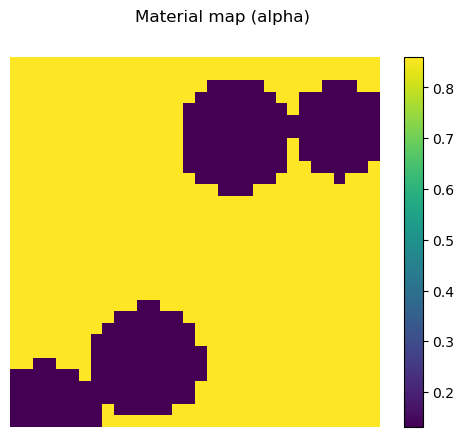

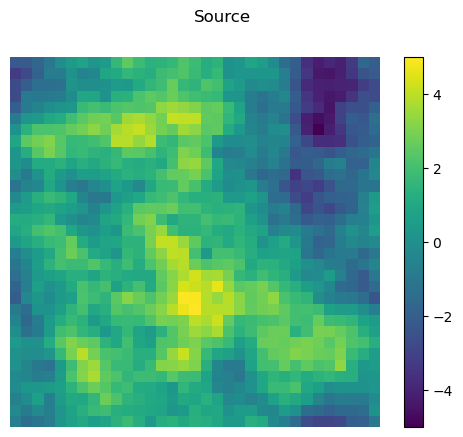

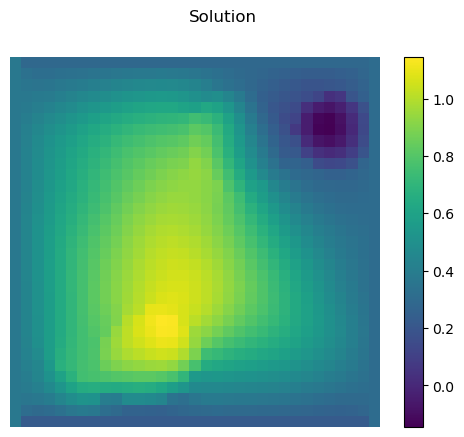

''

In [9]:
plot.plot_thermalfield(dirich_idx_train[k], ftitle='Dirichlet boundary index')

plot.plot_thermalfield(dirich_value_train[k], ftitle='Dirichlet boundary value')
plot.plot_thermalfield(neumann_idx_train[k], ftitle='Flux boundary index')
plot.plot_thermalfield(neumann_value_train[k], ftitle='Flux boundary value')
plot.plot_thermalfield(material_train[k], ftitle='Material map (alpha)')
plot.plot_thermalfield(f_train[k], ftitle='Source')
plot.plot_thermalfield(u_train[k], ftitle='Solution')
''''''

In [10]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    '''
    def __init__(self, size, n_elem, mode, dev):
        self.size = size # actual size of the plate
        self.mode = mode
        self.device = dev
        self.n_elem = n_elem
        self.h = size/n_elem
        self.v = torch.zeros((1, 1, n_elem+1, n_elem+1), requires_grad=False).double()
        self.f = torch.zeros((1, 1, n_elem+1, n_elem+1), requires_grad=False).double()
        self.net = self.InstantiateNetwork()
        self.jac = JacobiBlock(self.net, self.h, self.device, self.mode)

    def IsCoarsest(self):
        return self.n_elem == 2
        
    def InstantiateNetwork(self):
        model = PACFEANet(self.device, self.mode).double()
        model.requires_grad_(False)
        return model.to(self.device)

In [11]:
domain_size = 2
n_elem = 2**5
ku, kf = 1, 1
h = domain_size/n_elem
grid = SingleGrid(domain_size, n_elem=n_elem, mode='thermal', dev=device_predict)

In [12]:
solution_test, f_test, d_test, d_idx_test, t_test, t_idx_test, m_test = (torch.unsqueeze(u_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_train[k], 0).to(device_predict))


0 6.263498621938403
1 3.4968650492661624
2 2.5303344152086686
3 2.014788965146864
4 1.684889610023218
5 1.4519517736184775
6 1.2774051901033734
7 1.1413368213011827
8 1.0321762356101463
9 0.9426282619244376
10 0.8678220428964577
11 0.8043675846730113
12 0.7498304409201286
13 0.7024186245502552
14 0.6607859876301413
15 0.623903633755561
16 0.5909730966469187
17 0.5613662003387467
18 0.5345825199889127
19 0.5102187603902708
20 0.4879463799909441
21 0.4674950235398652
22 0.4486401098908993
23 0.4311934318829564
24 0.41499596539987754
25 0.39991231590156023
26 0.3858263904535955
27 0.37263799522976215
28 0.3602601378900189
29 0.34861687120564955
30 0.33764155556018294
31 0.32727544809615544
32 0.31746654847752576
33 0.30816864771271446
34 0.2993405387985196
35 0.2909453572147918
36 0.2829500263235858
37 0.27532478808315874
38 0.2680428035979008
39 0.26107981119904305
40 0.25441383221572467
41 0.24802491652092676
42 0.24189492144840608
43 0.2360073188700867
44 0.23034702617032266
45 0.22490

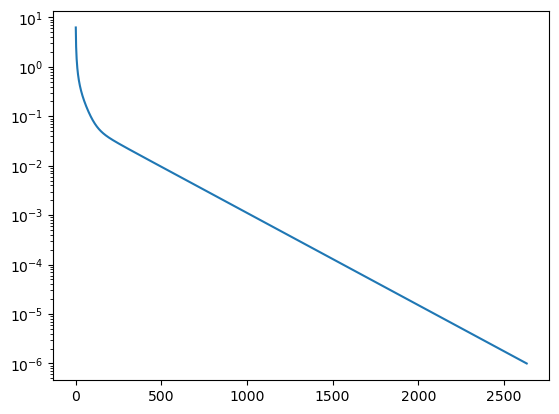

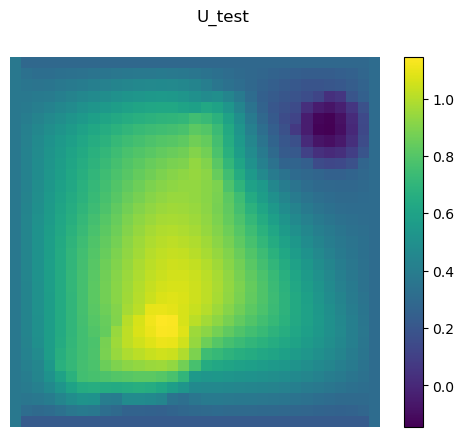

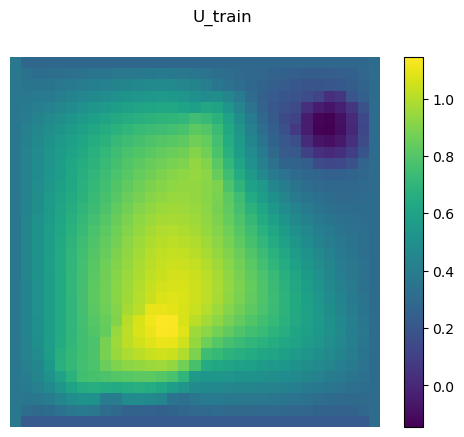

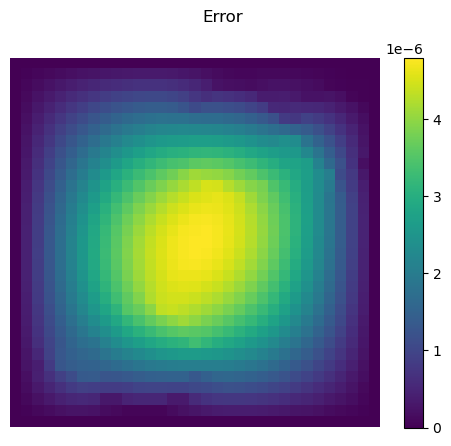

In [13]:
EPS = 1e-6
n_jac = 0
u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
u_test = grid.jac.reset_boundary(u_test, d_test, d_idx_test)
residual = d_idx_test*grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
res = torch.norm(residual).item() 
res_arr = [res]

print(n_jac, res)
while (abs(res) > EPS):
    u_test = grid.jac.jacobi_convolution(u_test, m_test, d_test, d_idx_test, None, None, h, f_test, t_test, t_idx_test)
    residual = d_idx_test*grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item() 
    res_arr.append(res)
    n_jac += 1
    print(n_jac, res)

print("Solution converges after", n_jac, "Jacobi iterations ")
plt.plot(res_arr)
plt.yscale('log')
plt.show()

plot.plot_thermalfield(u_test[0], "U_test")
plot.plot_thermalfield(solution_test[0], "U_train")
plot.plot_thermalfield(u_test[0]-solution_test[0], 'Error')

In [14]:
class PsiNet(nn.Module):
    def __init__(self, nb_layers=3, mode='thermal'):
        super(PsiNet, self).__init__()

        self.mode = mode
        self.kernel = 3
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2
            
        self.smoother = nn.ModuleList([nn.Conv2d(self.ku, self.ku, 3, padding=1, bias=False)
                                         for _ in range(nb_layers)])

    def forward(self, m, x, dirich_idx):
        '''
        m: material field
        x: error between Jacobi solution and initial guess '''
        
        return reduce(lambda acc, el: el(acc) * dirich_idx, self.smoother, x) # shape (bs, ku, h, w)

In [15]:
class AttentionNet(nn.Module):
    def __init__(self, nb_layers=3, mode='thermal'):
        super(PsiNet, self).__init__()

        self.mode = mode
        self.k_size = 3
        self.nb_layers = nb_layers
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2
            
        self.attention_map = nn.Sequential(
            nn.Conv2d(self.km, 1, kernel_size=2, padding=1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.Conv2d(1, self.k_size*self.k_size, kernel_size=1),
            #nn.BatchNorm2d(self.kernel*self.kernel)
            )
        
        self.pac_conv = nn.ModuleList([pac.PacConv2d(self.ku, self.ku, 3, padding=1, bias=False)
                                         for _ in range(nb_layers)])

    def forward(self, x, m, smoother, dirich_idx):
        '''
        x: error between Jacobi solution and initial guess 
        smoother: learned smoother (Psi) network '''

        bs0, ku0, h0, w0 = x.size()
        
        # get the material kernels
        attention_kernels = self.attention_map(m).view(bs0, 1, self.k_size, self.k_size, h0, w0) # shape (bs, 1, 3, 3, h, w)
             
        
        smoother_list = list(smoother.parameters()) # a list of length (nb_layers) kernels with shape (ku, ku, 3, 3)

        # for thermal problems, ku = 1
        # loop for each layer of smoother and get the kernel (3,3)

        new_x = F.unfold(x, kernel_size = 3, padding = 1).view(bs0, -1, h0, w0) # shape (bs, 9ku, h, w)
        
        #attention = self.nonlinear(attention) # shape (bs, 9, h, w)
        attention = attention.repeat(1, self.ku, 1, 1) # shape (bs, 9ku, h, w)
        attention_x = new_x * attention # shape (bs, 9ku, h, w)
        attention_x = self.merge(attention_x) # shape (bs, ku, h, w)
        return reduce(lambda acc, el: el(acc) * dirich_idx, self.smoother, attention_x) # shape (bs, ku, h, w)

In [16]:
class PsiIterator(nn.Module):
    def __init__(self, 
                 dev,
                 size=2, 
                 psi_net=None,
                 grid=None,
                 n=2**5,
                 nb_layers=3,
                 batch_size=1,
                 max_epochs=1000,
                 mode='thermal',
                 model_dir=model_dir):
        super(PsiIterator, self).__init__()
        self.size = size
        self.device = dev
        self.n = n
        self.h = size/n
        self.mode = mode
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.loss = nn.MSELoss()
        
        if(grid is None):
            self.grid = SingleGrid(size, n, mode=mode, dev=self.device)
        else:
            self.grid = grid

        if(psi_net is None):
            self.psi_net = PsiNet(nb_layers=nb_layers, mode=self.mode).to(self.device).double()
        else:
            self.psi_net = psi_net.to(self.device).double()
        self.psi_net.requires_grad_(False)

        self.optimizer = torch.optim.Adadelta(self.psi_net.parameters())
        self.model_dir=model_dir

    def PsiRelax(self, v, m, d, d_idx, term_KU=None, term_F=None, h=None, f=None, t=None, t_idx=None, num_sweeps_down=1):
        '''
        Perform a fixed number of Psi iteration
        '''
        u = v.clone()
        for _ in range(num_sweeps_down):
            jac_it = self.grid.jac.jacobi_convolution(u, m, d, d_idx, term_KU, term_F, h, f, t, t_idx)
            u = jac_it + self.psi_net(m, jac_it-u, d_idx) #- self.psi_net(m, jac_it-u, d_idx) 
        return u

    def RandomSampling(self, x):
        u = torch.randn_like(x).double().to(self.device)
        return u

    def TrainSingleEpoch(self, train_dataloader):
        running_loss = 0.
        for i, data in enumerate(train_dataloader):
            self.psi_net.train()
            dirich_idx_train, dirich_value_train, traction_idx_train, traction_value_train, material_train, f_train, u_train = data
        
            #print(u_train.shape)
            self.optimizer.zero_grad() # zero the gradients for every batch
            k = 1 #random.randint(1,20)

            uu = self.RandomSampling(f_train)
            u_out = self.PsiRelax(uu, material_train, dirich_value_train, dirich_idx_train, None, None, self.h, f_train, traction_value_train, traction_idx_train, k)
            loss_i = self.loss(u_out, u_train)
            loss_i.backward()
            self.optimizer.step()
        
            running_loss += loss_i.item()
    
        last_loss = running_loss/(i+1)
        return last_loss
    
    def Train(self, training_set):
        train_dataloader = DataLoader(training_set, batch_size=self.batch_size, shuffle=True)
        loss_train = torch.zeros((self.max_epochs, 1))
        avg_loss = self.TrainSingleEpoch(train_dataloader)
        loss_train[0] = avg_loss
        print('Step-0 loss:', avg_loss)

        for epoch in range(1, self.max_epochs):
            avg_loss = self.TrainSingleEpoch(train_dataloader)
            if(epoch % 50 == 0):
                print('Step-'+str(epoch)+' loss:', avg_loss)

            # save the model's state
            mpath = os.path.join(self.model_dir,model_name+'.pth')
            torch.save(self.psi_net.state_dict(), mpath)
            loss_train[epoch] = avg_loss
        return loss_train

In [17]:
max_epochs = 200
my_iterator = PsiIterator(device, batch_size=bs, mode='thermal', nb_layers=nb_layers, max_epochs=max_epochs)

loss_train = torch.zeros((max_epochs, 1))
if(train):
    loss_train = my_iterator.Train(training_set)

    plt.plot(loss_train)
    plt.ylabel('loss')
    plt.yscale('log')
    plt.xlabel('epoch')
    print("Average loss: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))

    # save the list
    torch.save(loss_train, os.path.join(model_dir,model_name+'.pt'))


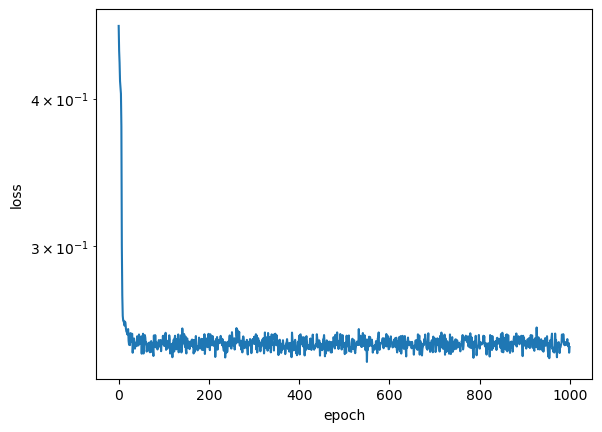

In [18]:
# import the learned model and loss train
my_net = PsiNet(nb_layers=nb_layers, mode='thermal').to(device_predict)
my_net.eval()
my_net.load_state_dict(torch.load(os.path.join(model_dir,smoother_model+'.pth')))
new_iterator = PsiIterator(device_predict, nb_layers=nb_layers, psi_net=my_net, grid=grid, batch_size=1)

my_loss = torch.load(os.path.join(model_dir,smoother_model+'.pt'))
plt.plot(my_loss)
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.savefig('results/smoother_loss.jpg', dpi=500, bbox_inches='tight')

In [19]:
u_test = torch.randn(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
u_test = new_iterator.grid.jac.reset_boundary(u_test, d_test, d_idx_test)
new_iterator.loss(u_test, solution_test)

tensor(1.2994, device='cuda:0', dtype=torch.float64)

In [20]:
residual = d_idx_test*new_iterator.grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
res = torch.norm(residual).item() # fix top, apply traction force at bottom boundary
res_arr_new = [res]
u_test = new_iterator.PsiRelax(u_test, m_test, d_test, d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
new_iterator.loss(u_test, solution_test)

tensor(0.3936, device='cuda:0', dtype=torch.float64)

In [21]:
u_test = new_iterator.PsiRelax(u_test, m_test, d_test, d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
new_iterator.loss(u_test, solution_test)

tensor(0.3097, device='cuda:0', dtype=torch.float64)

0 6.263498621938403
1 1.5185554152044924
2 0.6114323745514282
3 0.35796973905173773
4 0.2547198410411599
5 0.19847814971534525
6 0.16015439795699776
7 0.13204817574596278
8 0.1106814270937959
9 0.09425159043653425
10 0.08153384730739426
11 0.07164850327256758
12 0.06391658290145816
13 0.05781181992179643
14 0.05292580175986634
15 0.048946657924219726
16 0.045640090764403236
17 0.04283313076705388
18 0.04039984540829819
19 0.03824948700574491
20 0.03631703566952613
21 0.03455597012001378
22 0.032932905621175936
23 0.031423713038523995
24 0.030010757035485922
25 0.028680954465724592
26 0.02742441994120834
27 0.026233525339676444
28 0.025102247952372293
29 0.024025718517069986
30 0.022999907090581976
31 0.02202140379258042
32 0.02108726483813434
33 0.020194903566366718
34 0.01934201256920613
35 0.01852650740716528
36 0.017746485392953797
37 0.0170001949657196
38 0.016286012571015286
39 0.01560242491162486
40 0.014948015083758228
41 0.014321451558098204
42 0.013721479271267016
43 0.0131469

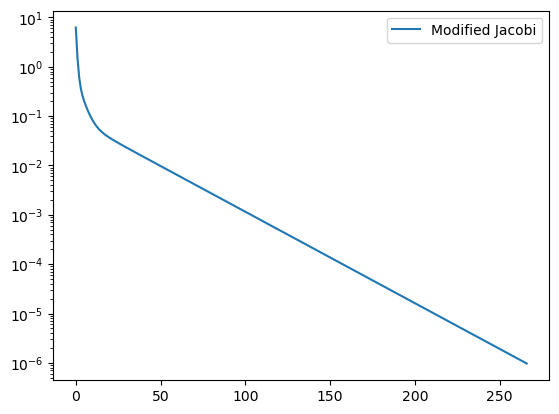

In [22]:
EPS = 1e-6
with torch.no_grad():
    n_new = 0
    u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
    u_test = new_iterator.grid.jac.reset_boundary(u_test, d_test, d_idx_test)
    residual = d_idx_test*new_iterator.grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item() # fix top, apply traction force at bottom boundary
    res_arr_new = [res]
    print(n_new, res)
    while (abs(res) > EPS and n_new < 1000):
        u_test = new_iterator.PsiRelax(u_test, m_test, d_test, d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*new_iterator.grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_new.append(res)
        n_new += 1
        print(n_new, res)

print("Solution converges after", n_new, "iterations ")
plt.plot(res_arr_new, label='Modified Jacobi')
#plt.plot(res_arr, label='Jacobi')
plt.yscale('log')
plt.legend()
plt.show()

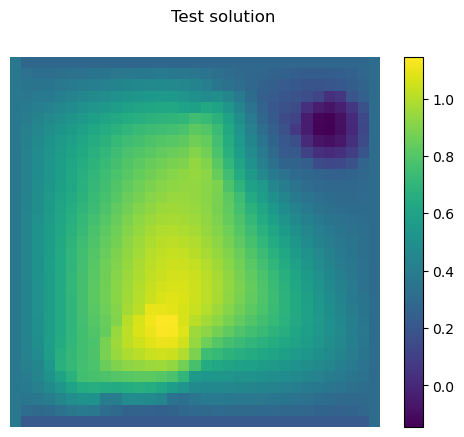

In [23]:
plot.plot_thermalfield(u_test[0], 'Test solution')

In [24]:
# test multigrid performance

class RestrictionNet(nn.Module):
    '''Given an initial kernel, inter-grid communication'''
    def __init__(self, chs):
        super(RestrictionNet, self).__init__()
        self.chs = chs
        self.net = nn.Conv2d(in_channels=chs, out_channels=chs, kernel_size=3, stride=2, bias=False, groups=chs) # restriction
        self.edge_net = nn.Conv1d(in_channels=chs, out_channels=chs, kernel_size=3, stride=2, bias=False, groups=chs) # restrict the edge boundaries
        for i in range(self.chs):
            self.net.state_dict()['weight'][i][0] = torch.asarray([[1., 2., 1.],
                                                                   [2., 4., 2.],
                                                                   [1., 2., 1.]]) / 4.0
            self.edge_net.state_dict()['weight'][i][0] = torch.asarray([1., 2., 1.]) / 2.0
    
    def forward(self, x):
        internal = self.net(x[:, :, 1:-1, 1:-1].clone())
        x_C = F.pad(internal,(1,1,1,1),"constant",0) # coarse grid field
        x_C[:, :,  0, 1:-1] = self.edge_net(x[:, :, 0, 1:-1].clone())
        x_C[:, :, -1, 1:-1] = self.edge_net(x[:, :, -1, 1:-1].clone())
        x_C[:, :, 1:-1,  0] = self.edge_net(x[:, :, 1:-1, 0].clone())
        x_C[:, :, 1:-1, -1] = self.edge_net(x[:, :, 1:-1, -1].clone())
        x_C[:,:,0,0] = x[:,:,0,0]
        x_C[:,:,0,-1] = x[:,:,0,-1]
        x_C[:,:,-1,0] = x[:,:,-1,0]
        x_C[:,:,-1,-1] = x[:,:,-1,-1]
        return x_C


class ProlongationNet(nn.Module):
    '''Given an initial P kernel'''
    def __init__(self, chs):
        super(ProlongationNet, self).__init__()
        self.chs = chs
        self.net = nn.ConvTranspose2d(in_channels=chs,out_channels=chs, kernel_size=3, stride=2, padding=1, bias=False, groups=chs) # interpolation
        for i in range(self.chs):
            self.net.state_dict()['weight'][i][0] = torch.asarray([[1., 2., 1.],
                                                                   [2., 4., 2.],
                                                                   [1., 2., 1.]]) / 4.0
            
    def forward(self, x): 
        return self.net(x)

In [25]:
class MultiGrid(nn.Module):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n, pacnet, device, nb_layers, mode='thermal', iterator = 'jac'):
        super(MultiGrid, self).__init__()

        # Problem parameters
        self.device = device
        self.size = 2.
        self.nb_layers = nb_layers
        self.n = n # number of grid intervals for finest grid edges
        self.L = int(np.log2(n)) # multigrid iteration
        self.pacnet = pacnet
        self.iterator = iterator
        
        self.mode = mode
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2

        self.iterators = self.IteratorDict() # dictionary of iterators

        # Inter-grid communication network models
        self.conv = RestrictionNet(self.kf).double().to(device)
        self.deconv = ProlongationNet(self.ku).double().to(device)
        
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)

        self.mse_loss = nn.MSELoss()
    
    def IteratorDict(self):
        iterators = {}
        for i in range(self.L):
            prob_size = int(self.n/(2.**i))
            iterators[i] = PsiIterator(self.device, size=self.size, psi_net=self.pacnet, n=prob_size, nb_layers=self.nb_layers, mode=self.mode)
        return iterators
            
    def ProblemDictArray(self, u0, f, t, t_idx, d, d_idx, m):
        '''
        Array of dictionary that stores the problem hierarchy
        There are two approaches that can be used to create grid hierarchy:
        1) mat = F.conv2d(mat.reshape((1,1,n,n)), torch.ones((1,1,1,1)), stride=2)
        2) mat = F.max_pool2d(mat.reshape((1,1,n,n)), kernel_size=2, stride=2)
        '''
        kernel_u = torch.ones((self.ku,1,1,1)).double().to(self.device)
        kernel_f = torch.ones((self.kf,1,1,1)).double().to(self.device)
        prob = {}
        prob['h'] = self.size/self.n
        prob['u0'] = self.iterators[0].grid.jac.reset_boundary(u0, d, d_idx)
        prob['f'], prob['t'], prob['t_idx'] = f.clone(), t.clone(), t_idx.clone()
        prob['d'], prob['d_idx'], prob['m'] = d.clone(), d_idx.clone(), m.clone()
        self.p_arr = [prob]
        for i in range(self.L-1):
            prob = {}
            prob['h'] = self.size/self.n*(2.**(i+1))
            prob['u0'] = F.conv2d(self.p_arr[i]['u0'], kernel_u, stride=2, groups=self.ku)
            prob['f'] = F.conv2d(self.p_arr[i]['f'], kernel_f, stride=2, groups=self.kf)
            prob['t'] = F.conv2d(self.p_arr[i]['t'], kernel_f, stride=2, groups=self.kf)
            prob['t_idx'] = F.conv2d(self.p_arr[i]['t_idx'], kernel_f, stride=2, groups=self.kf)
            prob['d'] = 0.*F.conv2d(self.p_arr[i]['d'], kernel_u, stride=2, groups=self.ku) # Dirichlet boundary is homogeneous at coarse grids
            prob['d_idx'] = F.conv2d(self.p_arr[i]['d_idx'], kernel_u, stride=2, groups=self.ku)
            prob['m'] = F.max_pool2d(self.p_arr[i]['m'], kernel_size=2, stride=2)
            self.p_arr.append(prob)

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        '''
        rFC = self.conv(rF.clone())
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    def forward(self, k):
        U = self.p_arr[0]['u0'].clone()
        for i in range(k-1):
            U = self.Step(U).detach()
        self.last_v = U.clone()
        return self.Step(U)

    def Relax(self, iter, u, m, d, d_idx, term_KU=None, term_F=None, h=None, f=None, t=None, t_idx=None, n_iter=1):
        if(self.iterator == 'jac'):
            return iter.grid.jac.jacobi_convolution(u, m, d, d_idx, term_KU, term_F, h, f, t, t_idx)
        else:
            return iter.PsiRelax(u, m, d, d_idx, term_KU, term_F, h, f, t, t_idx, n_iter)

    def Step(self, v):
        '''Input v is the initial solution on the finest grid'''
        n_relax = 1 # number of relaxations        
        self.iterators[0].grid.v = self.Relax(self.iterators[0], v, self.p_arr[0]['m'], 
                                              self.p_arr[0]['d'], self.p_arr[0]['d_idx'],
                                              None, None,
                                              self.p_arr[0]['h'], self.p_arr[0]['f'], 
                                              self.p_arr[0]['t'], self.p_arr[0]['t_idx'], 
                                              n_relax)
        self.iterators[0].grid.f = self.iterators[0].grid.net.term_F

        for j in range(0, self.L-1):
            # calculate fine grid residual
            rF = self.iterators[j].grid.net(u=self.iterators[j].grid.v, material_input=self.p_arr[j]['m'],
                                            term_F=self.iterators[j].grid.f)
            self.iterators[j+1].grid.f = self.Restrict(rF)
            self.iterators[j+1].grid.v = torch.zeros_like(self.iterators[j+1].grid.f) 
            self.iterators[j+1].grid.v = self.Relax(self.iterators[j+1], self.iterators[j+1].grid.v, 
                                              self.p_arr[j+1]['m'], 
                                              self.p_arr[j+1]['d'], self.p_arr[j+1]['d_idx'],
                                              term_F=self.iterators[j+1].grid.f, 
                                              n_iter=n_relax)

        self.iterators[self.L-1].grid.v = self.Relax(self.iterators[self.L-1], self.iterators[self.L-1].grid.v, 
                                              self.p_arr[self.L-1]['m'], 
                                              self.p_arr[self.L-1]['d'], self.p_arr[self.L-1]['d_idx'],
                                              term_F=self.iterators[self.L-1].grid.f, 
                                              n_iter=n_relax)

        for j in range(self.L-2,-1,-1):
            eF_delta = self.Interpolate(self.iterators[j+1].grid.v)
            self.iterators[j].grid.v = self.iterators[j].grid.v + eF_delta
            self.iterators[j].grid.v = self.Relax(self.iterators[j], self.iterators[j].grid.v, 
                                              self.p_arr[j]['m'], 
                                              self.p_arr[j]['d'], self.p_arr[j]['d_idx'],
                                              term_F=self.iterators[j].grid.f, 
                                              n_iter=n_relax)

            # zero out the previous level solution
            self.iterators[j+1].grid.v *= 0. 

        return self.iterators[0].grid.v 

In [26]:
bs = 5
train_dataloader = DataLoader(test_set, batch_size=bs, shuffle=True)
dirich_idx_train, dirich_value_train, neumann_idx_train, neumann_value_train, material_train, f_train, u_train = next(iter(train_dataloader))
k=2
solution_test, f_test, d_test, d_idx_test, t_test, t_idx_test, m_test = (torch.unsqueeze(u_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_train[k], 0).to(device_predict))


In [27]:
with torch.no_grad():
    n = n_test
    h = 2./n
    n_mg_jac = 0
    my_net.eval()
    mg_jac = MultiGrid(n=n, pacnet=my_net, nb_layers=nb_layers, device=device, iterator='jac') # create a multigrid model
    u_mg_jac = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    mg_jac.ProblemDictArray(u_mg_jac,f_test,t_test,t_idx_test,d_test,d_idx_test,m_test)
    u_mg_jac = mg_jac.p_arr[0]['u0']
    residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgjac = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        #u_mg = mg_jac.Relax(mg_jac.iterators[0], u_mg, m_test, d_test,d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_mgjac.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')


0 32.43334523381806
1 7.9991573035114065
2 2.5329256456404496
3 0.9404633080216639
4 0.3930697177431508
5 0.17643969694285205
6 0.08255879350821813
7 0.03966101394699761
8 0.01940801329119427
9 0.009630321309688886
10 0.0048313268638953055
11 0.002445461008249975
12 0.0012469617066963071
13 0.0006397612268425404
14 0.0003299347172233241
15 0.0001708943208622839
16 8.884154376816914e-05
17 4.6327384349216156e-05
18 2.422006271831483e-05
19 1.2689491934751218e-05
20 6.660230686828539e-06
21 3.5009034706598318e-06
22 1.8425038616841668e-06
23 9.706986719893063e-07
Solution converges after 23 Jacobi multigrid iterations in 0.19913792610168457 seconds.


In [28]:
with torch.no_grad():
    h = 2./n
    n_mg_psi = 0
    mg_jac = MultiGrid(n=n, pacnet=my_net, nb_layers=nb_layers, device=device, iterator='psi') # create a multigrid model
    u_mg_psi = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    mg_jac.ProblemDictArray(u_mg_psi,f_test,t_test,t_idx_test,d_test,d_idx_test,m_test)
    u_mg_psi = mg_jac.p_arr[0]['u0']
    residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_psi, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgpsi = [res]
    print(n_mg_psi, res)

    start = time.time()
    while (abs(res) > EPS and n_mg_psi < 1000):
        u_mg_psi = mg_jac.Step(u_mg_psi)
        #u_mg = mg_jac.Relax(mg_jac.iterators[0], u_mg, m_test, d_test,d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_psi, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_mgpsi.append(res)
        n_mg_psi += 1
        print(n_mg_psi, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_psi, "Psi-Jacobi multigrid iterations in", end-start, 'seconds.')


0 32.43334523381806
1 2.4312946844342243
2 0.2879401184163905
3 0.054862755975077435
4 0.014820096707335953
5 0.004504463989177461
6 0.0014148308225440751
7 0.00044872854638431173
8 0.00014274039908422113
9 4.54427952547846e-05
10 1.4468579575023354e-05
11 4.605966653004288e-06
12 1.4659303922105933e-06
13 4.664394246108583e-07
Solution converges after 13 Psi-Jacobi multigrid iterations in 0.13957977294921875 seconds.


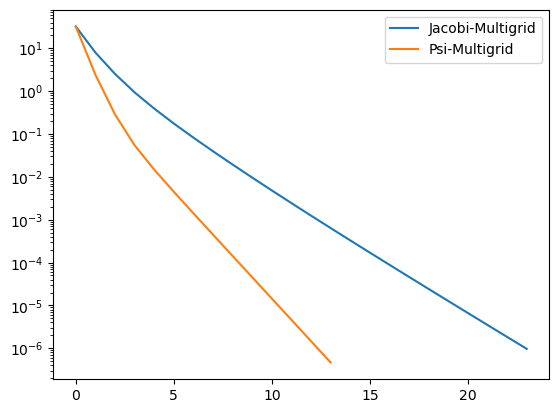

In [29]:
plt.plot(res_arr_mgjac, label='Jacobi-Multigrid')
plt.plot(res_arr_mgpsi, label='Psi-Multigrid')
plt.yscale('log')
plt.legend()
plt.show()

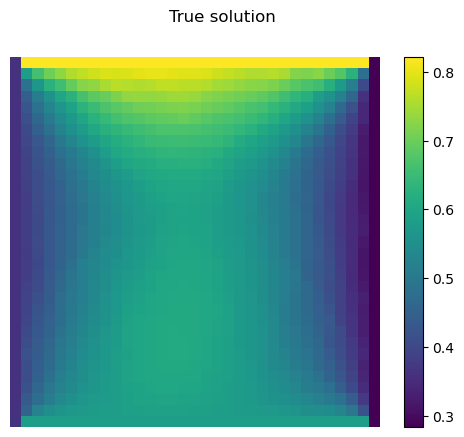

In [30]:
plot.plot_thermalfield((solution_test).reshape(n+1,n+1), 'True solution')

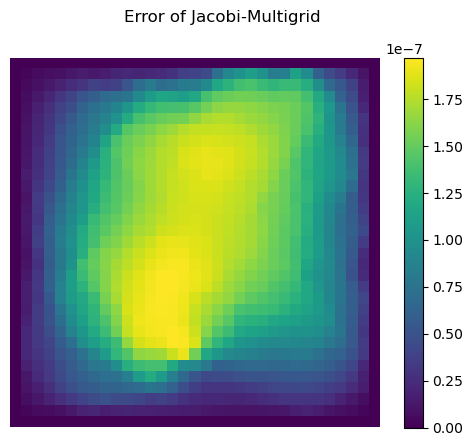

In [31]:
plot.plot_thermalfield((u_mg_jac-solution_test).reshape(n+1,n+1), 'Error of Jacobi-Multigrid')

In [32]:
u_mg_jac-solution_test

tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 3.4901e-09, 5.3913e-09,  ..., 2.2913e-08,
           1.0204e-08, 0.0000e+00],
          [0.0000e+00, 5.1687e-09, 8.9767e-09,  ..., 3.7766e-08,
           1.5925e-08, 0.0000e+00],
          ...,
          [0.0000e+00, 7.6205e-09, 1.2778e-08,  ..., 1.3734e-08,
           7.5606e-09, 0.0000e+00],
          [0.0000e+00, 3.8295e-09, 5.9993e-09,  ..., 6.4147e-09,
           3.3139e-09, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]]], device='cuda:0', dtype=torch.float64)

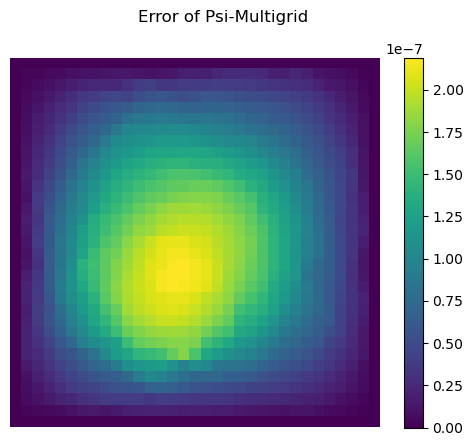

In [33]:
plot.plot_thermalfield((u_mg_psi.detach()-solution_test).reshape(n+1,n+1), 'Error of Psi-Multigrid')

In [34]:
u_mg_psi.detach()-solution_test

tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 2.7776e-09, 3.8497e-09,  ..., 5.2166e-09,
           2.1743e-09, 0.0000e+00],
          [0.0000e+00, 3.7657e-09, 6.4270e-09,  ..., 8.7597e-09,
           3.6982e-09, 0.0000e+00],
          ...,
          [0.0000e+00, 6.4368e-09, 1.0501e-08,  ..., 6.8291e-09,
           3.4605e-09, 0.0000e+00],
          [0.0000e+00, 3.2575e-09, 4.9737e-09,  ..., 3.4780e-09,
           1.7762e-09, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]]], device='cuda:0', dtype=torch.float64)